In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.optimize import fsolve
from scipy.optimize import minimize_scalar
from env.LogitDemandPricingEnv import LogitDemandPricingEnv
np.random.seed(42)
import os
FIGURE_DIR = "./figure"
DATA_DIR = "./data"

In [2]:
# A function to convert joint action (i,j) to index in Q-table  
def joint_to_index(i, j, grid_size):
    """Convert joint action (i,j) to index in Q-table."""
    return i * grid_size + j

class QLearningAgent:
    """
    Q-learning agent for the duopoly‐logit pricing game.
      - State s_t = price index played in previous round (0…n_actions-1).
      - Action a_t ∈ {0…n_actions-1} picks the next price index.
      - Greedy policy: always pick argmax_a Q[s, a].
    """
    def __init__(
        self,
        n_actions: int,
        alpha: float = 0.1,
        gamma: float = 0.9,
        init_low: float = 10.0,
        init_high: float = 20.0,
        cost: float = 2.0,
        prices: np.ndarray = None,
    ):
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.t = 0 # time step
        self.omega = 1.5e-5
        self.cost = cost
        self.prices = prices  # array of actual price values
        # Q-table: rows = states (previous price idx), cols = actions (next price idx)
        self.Q = np.random.uniform(init_low, init_high, size=(n_actions**2, n_actions))

    def take_action(self, state: int) -> int:
        """epsilon-Greedy: epsilon = exp(-t * omega)"""
        epsilon = np.exp(-self.t * self.omega)
        if np.random.rand() < epsilon:
            # Explore: pick random action
            action = np.random.randint(self.n_actions)
        else:
            # Exploit: pick best action according to Q-table
            action = int(np.argmax(self.Q[state]))
        return action

    def update(self, state: int, action: int, reward: float, next_state: int):
        """One‐step Q‐learning update."""
        best_next = np.max(self.Q[next_state])
        td_target = reward + self.gamma * best_next
        td_error = td_target - self.Q[state, action]
        self.Q[state, action] += self.alpha * td_error
        # update the time step
        self.t += 1
    

class QLearningRuleAgent:
    """
    Q-learning agent for the duopoly‐logit pricing game.
    Instead of using a Q-table to pick price index, this agent uses a Q-table to pick one of the following rules:
        - Rule 0: pick the price that matches the price index played by the other player in the previous round.
        - Rule 1: pick the price that is one index higher than the price index played by the other player in the previous round. (if the index is greater than n_actions-1, just pick n_actions-1)
        - Rule 2: pick the price that is one index lower than the price index played by the other player in the previous round. (if the index is less than or equal to 0, just pick 0)
        - Rule 3: Do nothing and keep the price index played in the previous round.
    Specific restriction: The RuleAgent can only pick one of the four rules, once picked, the agent will keep using the same rule for 4 rounds before next action change.
      - State s_t = price index played in previous round by the two players (i,j).
      - Action a_t ∈ {0,1,2,3} picks the next rule.
      - Greedy policy: always pick argmax_a Q[s, a].
    """
    def __init__(self, n_actions, alpha=0.1, gamma=0.9, cost=2.0, prices=None,):
        self.n_price_actions = n_actions      # e.g. 25 price levels
        self.n_rules = 4                      # exactly 4 rules
        self.alpha = alpha
        self.gamma = gamma
        self.omega = 1.5e-5
        self.t = 0                            # global time step for ε
        # Q-table: rows = joint‐state index, cols = rule‐index (0…3)
        self.Q = np.random.uniform(10, 20, size=(n_actions**2, self.n_rules))
        # bookkeeping for “stick with same rule for 4 periods”
        self.current_rule = 0
        self.rule_timer = 4   # so we pick fresh immediately on t=0
        # track last price index
        self.last_price_idx = None

    def take_action(self, state, rival_pre_price_idx, own_pre_price_idx):
        # state encodes (own_pre, rival_pre); so we could also unpack it
        # but we pass in rival_pre and own_pre explicitly.
        # if self.rule_timer >= 4:
        if self.rule_timer >= 4:
            epsilon = np.exp(-self.t * self.omega)
            if np.random.rand() < epsilon:
                new_rule = np.random.randint(self.n_rules)
            else:
                new_rule = int(np.argmax(self.Q[state]))
            self.current_rule = new_rule
            self.rule_timer = 0
        price_idx = self._apply_rule(self.current_rule,
                                     rival_pre_price_idx,
                                     own_pre_price_idx)
        self.rule_timer += 1
        return price_idx

    def _apply_rule(self, rule, rival_idx, own_idx):
        if rule == 0:
            return rival_idx
        elif rule == 1:
            return min(rival_idx + 1, self.n_price_actions - 1)
        elif rule == 2:
            return max(rival_idx - 1, 0)
        elif rule == 3:
            # hold your own last price
            return own_idx

    def update(self, state, rule, reward, next_state):
        best_next = np.max(self.Q[next_state])
        td_target = reward + self.gamma * best_next
        self.Q[state, rule] += self.alpha * (td_target - self.Q[state, rule])
        self.t += 1

class DummyQLearningRuleAgent:
    """
    A Q-learning agent with no state representation — learns expected profit of each rule.
    Only tracks Q-values for each rule: Q[rule] of shape (n_rules,)
    
    - Actions are rules:
        Rule 0: Match rival's previous price index.
        Rule 1: Raise rival's previous price index by 1 (capped at max).
        Rule 2: Lower rival's previous price index by 1 (floored at 0).
        Rule 3: Repeat own previous price index.
    - Uses ε-greedy policy with decaying ε.
    - Commits to a chosen rule for 4 consecutive rounds.
    """

    def __init__(self, n_actions, alpha=0.1, gamma=0.9, cost=2.0):
        self.n_price_actions = n_actions
        self.n_rules = 4
        self.alpha = alpha
        self.gamma = gamma
        self.omega = 1.5e-5
        self.t = 0  # global time step for ε decay

        # Q table: value estimates for each rule (no state dimension)
        self.Q = np.random.uniform(10, 20, size=(self.n_rules,))

        # Rule persistence for 4 rounds
        self.current_rule = 0
        self.rule_timer = 4  # so we pick fresh on first round

        # Keep track of last price index
        self.last_price_idx = None

    def take_action(self, rival_pre_price_idx, own_pre_price_idx):
        if self.rule_timer >= 4:
            epsilon = np.exp(-self.t * self.omega)
            if np.random.rand() < epsilon:
                new_rule = np.random.randint(self.n_rules)
            else:
                new_rule = int(np.argmax(self.Q))
            self.current_rule = new_rule
            self.rule_timer = 0

        price_idx = self._apply_rule(self.current_rule, rival_pre_price_idx, own_pre_price_idx)
        self.rule_timer += 1
        return price_idx

    def _apply_rule(self, rule, rival_idx, own_idx):
        if rule == 0:
            return rival_idx
        elif rule == 1:
            return min(rival_idx + 1, self.n_price_actions - 1)
        elif rule == 2:
            return max(rival_idx - 1, 0)
        elif rule == 3:
            return own_idx

    def update(self, rule, reward):
        # TD update with no state
        td_target = reward  # no next Q since stateless
        self.Q[rule] += self.alpha * (td_target - self.Q[rule])
        self.t += 1

In [3]:
def simulate_QpQr(env, periods, alpha=0.1, gamma=0.9):
    """
    Run a Q-learning vs. Q-learning-rule price competition for `periods` steps.
    
    Returns
    -------
    history : np.ndarray, shape (periods,)
        The time series of firm 1's chosen prices.
    """
    # --- 1) Create two agents with fresh Q‐tables
    n_actions = len(env.prices)
    agent0 = QLearningAgent(
        n_actions=n_actions,
        alpha=alpha,
        gamma=gamma,
        prices=env.prices,
        cost=env.cost
    )
    agent1 = QLearningRuleAgent(
        n_actions=n_actions,
        alpha=alpha,
        gamma=gamma,
        prices=env.prices,
        cost=env.cost,
    )
    # print(f"Q-table shape: {agent0.Q.shape}") 
    

    history0 = np.zeros(periods)
    history1 = np.zeros(periods)

    history_action_0 = np.zeros(periods)
    history_action_1 = np.zeros(periods)

    history_profit_0 = np.zeros(periods)
    history_profit_1 = np.zeros(periods)

    # --- 2) Initialize environment & states
    # Gymnasium reset returns (obs, info)
    (obs_0, obs_1), info = env.reset()
    state0 = joint_to_index(obs_0, obs_1, n_actions)
    state1 = joint_to_index(obs_0, obs_1, n_actions)

    # --- 3) Main loop
    for t in range(periods):
        # each agent picks greedily by Q
        a0 = agent0.take_action(state0)
        a1_price_idx = agent1.take_action(state=state1,
                                          rival_pre_price_idx=a0,
                                          own_pre_price_idx=obs_1)
        # step the env; unpack according to Gymnasium API
        (next_obs_0, next_obs_1), (r1, r2), terminated, truncated, info = env.step((a0, a1_price_idx))


        # map next observations to next states
        next_state0 = joint_to_index(next_obs_0, next_obs_1, n_actions) # both are the same. State is a number for Q-table, obs is number of price index.
        next_state1 = joint_to_index(next_obs_0, next_obs_1, n_actions) # both are the same

        # Q‐learning updates
        agent0.update(state0, a0, r1, next_state0)
        agent1.update(state1, agent1.current_rule, r2, next_state1)

        # record firm 0’s actual price
        history0[t] = env.prices[a0]
        history1[t] = env.prices[a1_price_idx]

        # record each firm's action
        history_action_0[t] = a0
        history_action_1[t] = agent1.current_rule

        # record each firm's profit
        history_profit_0[t] = r1
        history_profit_1[t] = r2
        # roll over state
        obs_0, obs_1 = next_obs_0, next_obs_1
        state0, state1 = next_state0, next_state1

        # optionally break if episode ends
        if terminated or truncated:
            break

    return history1, history_action_1, history_profit_1  # shape (periods,). Stores firm-1 price history, which is rule-based.

def simulate_batch(periods, runs, alpha, gamma, env, simfunc):
    """
    Run `runs` simulations in batch.

    Returns
    -------
    history1_all         : np.ndarray, shape (runs, periods)
        The time series of firm 1's chosen prices for each run.
    history_action_1_all : np.ndarray, shape (runs, periods)
        The time series of firm 1's actions for each run. Here is the rule index.
    history_profit_1_all : np.ndarray, shape (runs, periods)
        The time series of firm 1's profits for each run.
    """
    history1_all = []
    history_action_1_all = []
    history_profit_1_all = []

    for _ in range(runs):
        h1, ha1, hp1 = simfunc(env, periods, alpha, gamma)
        history1_all.append(h1)
        history_action_1_all.append(ha1)
        history_profit_1_all.append(hp1)

    return (
        np.array(history1_all),         # shape (runs, periods)
        np.array(history_action_1_all),
        np.array(history_profit_1_all)
    )

def move_average(x, window):
    """Compute moving average of x with window size."""
    return np.convolve(x, np.ones(window), 'valid') / window

def plot_percentiles(percentiles, periods, title, save_path=None, ne_price=None, mono_price=None):
    """
    Plot min, 25th, median, 75th, and max percentile lines.
    percentiles shape = (5, periods).
    Plot the monopoly price and Nash equilibrium price if provided as dashed lines.
    """
    window = 300
    x = np.arange(periods-window+1)
    labels_linestyle = [
        ('Min',           '-'),
        ('25th percentile','--'),
        ('Median',        '-'),
        ('75th percentile','--'),
        ('Max',           '-'),
    ]
    plt.figure(figsize=(10, 4))
    for idx, (label, ls) in enumerate(labels_linestyle):
        lw = 2 if label == 'Median' else 1
        # moving ave
        move_ave_pct = move_average(percentiles[idx], window=window)
        plt.plot(x, move_ave_pct, linestyle=ls, linewidth=lw, label=label)
    # plot monopoly price
    if ne_price is not None:
        plt.axhline(y=ne_price, color='grey', linestyle='--', label='Competitive Price (NE)')
    if mono_price is not None:
        plt.axhline(y=mono_price, color='grey', linestyle='--', label='Monopoly Price')
    plt.title(title)
    plt.xlabel("Period")
    plt.ylabel("Price")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

def save_simulation_results(price_hist, action_hist, profit_hist, file_prefix, data_dir="DATA_DIR"):
    """
    Save simulation results of price, action, and profit histories to CSV files.

    Parameters:
    - price_hist (ndarray): Array of shape (runs, periods) for price history.
    - action_hist (ndarray): Array of shape (runs, periods) for action history.
    - profit_hist (ndarray): Array of shape (runs, periods) for profit history.
    - file_prefix (str): Prefix for output CSV filenames (e.g., 'q-learning-vs-q-learning-rule-price-competition').
    - data_dir (str): Directory where CSVs are saved.
    """

    run = price_hist.shape[0]

    df_price = pd.DataFrame(price_hist[:, -1000:].T, columns=[f"Run {i+1}" for i in range(run)])
    df_action = pd.DataFrame(action_hist[:, -1000:].T, columns=[f"Run {i+1}" for i in range(run)])
    df_profit = pd.DataFrame(profit_hist[:, -1000:].T, columns=[f"Run {i+1}" for i in range(run)])

    os.makedirs(data_dir, exist_ok=True)
    df_price.to_csv(os.path.join(data_dir, f"{file_prefix}-price.csv"), index=False)
    df_action.to_csv(os.path.join(data_dir, f"{file_prefix}-action.csv"), index=False)
    df_profit.to_csv(os.path.join(data_dir, f"{file_prefix}-profit.csv"), index=False)

    print(f"Simulation complete. Data saved to CSV files with prefix '{file_prefix}'.")

Now we simulate the Q-Price v.s. Q-Rule competition. In this case, the convergence speed is significantly faster than the simple Q-Q case. What's more, the prices are even higher than the Q-Q scenario.
* A potential next step is to investigate what is going on in the Q-table.
* Next, we should include the Q-Rule v.s. Q-Rule scenario.
* Finally, we examine if the results hold given the Amazon-Featured Offer mechanis.

Price history shape: (50, 600000)


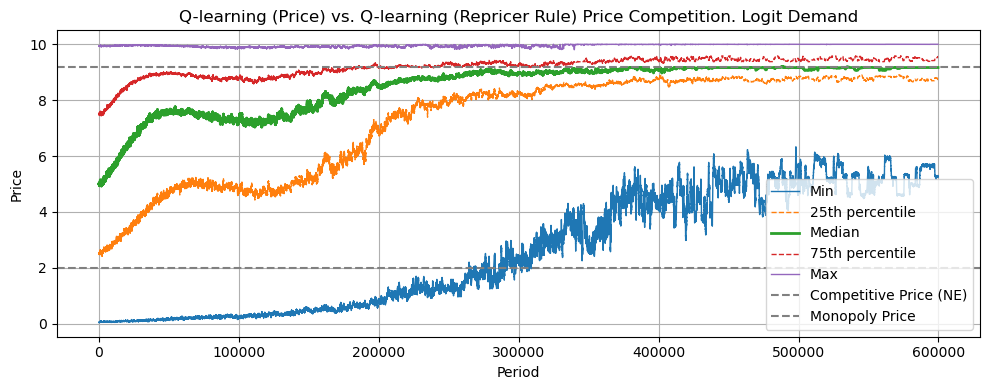

In [4]:
# Run the simulation
# run = 100
# periods = 200000 # need to increase to 90,0000 if we need 100 grids.
run=50 # later we only need 20 to get the percentiles.
periods = 600_000
# periods = 1000
alpha = 0.15
gamma = 0.9
env = LogitDemandPricingEnv(
    price_min = 0.01,
    price_max = 10.0,
    grid_size = 25,
    marginal_cost = 2.0,
    beta = 0.95,
    a_0=0, # parameter for logit demand. OUtside option
    a_12=10, # parameter for logit demand. Inside option
    mu = 0.25 # parameter for logit demand. Vertical differentiation
)

# Calculate monopoly price and NE price
# Monopoly Price
func_mono_profit = lambda p: (p - env.cost) * (np.exp((env.a_12 - p) / env.mu) / (np.exp((env.a_12 - p) / env.mu) + np.exp((env.a_0) / env.mu)))
p_mono = minimize_scalar(lambda p: -func_mono_profit(p), bounds=(env.price_min, env.price_max), method='bounded').x
p_mono = np.round(p_mono, 2)
# Competitive Price
def func_nash_equilibrium(p_i, p_j):
    d_i = np.exp((env.a_12 - p_i) / env.mu) / (np.exp((env.a_12 - p_i) / env.mu) + np.exp((env.a_12 - p_j) / env.mu) + np.exp((env.a_0) / env.mu))
    d_j = np.exp((env.a_12 - p_j) / env.mu) / (np.exp((env.a_12 - p_i) / env.mu) + np.exp((env.a_12 - p_j) / env.mu) + np.exp((env.a_0) / env.mu))
    return (p_i - env.cost) * d_i, (p_j - env.cost) * d_j
def equations(p):
    p_i, p_j = p
    return func_nash_equilibrium(p_i, p_j)
p_nash = fsolve(equations, (env.price_min, env.price_min))[0]

batch = simulate_batch(
    periods=periods,
    runs=run,
    alpha=alpha,
    gamma=gamma,
    env=env,
    simfunc=simulate_QpQr
)
price_hist, action_hist, profit_hist = batch
print(f"Price history shape: {price_hist.shape}")

# plot the price history percentiles
pc = np.percentile(price_hist, [0, 25, 50, 75, 100], axis=0)
plot_percentiles(
    percentiles=pc,
    periods=periods,
    title="Q-learning (Price) vs. Q-learning (Repricer Rule) Price Competition. Logit Demand",
    save_path=os.path.join(FIGURE_DIR, "q-learning-vs-q-learning-rule-price-competition.png"),
    ne_price=p_nash,
    mono_price=p_mono
)

In [5]:
# save the last 1000 periods of price history, action history, and profit history 
save_simulation_results(
    price_hist=price_hist[:,-1000:],
    action_hist=action_hist[:,-1000:],
    profit_hist=profit_hist[:,-1000:],
    file_prefix="q-learning-vs-q-learning-rule-price-competition",
    data_dir=DATA_DIR
)

Simulation complete. Data saved to CSV files with prefix 'q-learning-vs-q-learning-rule-price-competition'.


## Q-Rule Q-Rule scenario

In [ ]:
# --- 1) Define simulate_QrQr: two rule-based agents competing
def simulate_QrQr(env, periods, alpha=0.1, gamma=0.9):
    """
    Run a Q-learning-rule vs. Q-learning-rule price competition for `periods` steps.
    
    Returns
    -------
    history : np.ndarray, shape (periods,)
        The time series of firm 1's chosen prices.
    """
    n_actions = len(env.prices)
    # both agents now use the rule-agent
    agent0 = QLearningRuleAgent(n_actions, alpha=alpha, gamma=gamma, prices=env.prices, cost=env.cost)
    agent1 = QLearningRuleAgent(n_actions, alpha=alpha, gamma=gamma, prices=env.prices, cost=env.cost)
    
    history0 = np.zeros(periods)
    history1 = np.zeros(periods)

    history_action_0 = np.zeros(periods)
    history_action_1 = np.zeros(periods)

    history_profit_0 = np.zeros(periods)
    history_profit_1 = np.zeros(periods)

    (obs_0, obs_1), info = env.reset()
    state = joint_to_index(obs_0, obs_1, n_actions)

    for t in range(periods):
        # each rule-agent picks a price index
        a0 = agent0.take_action(state, rival_pre_price_idx=obs_1, own_pre_price_idx=obs_0)
        a1 = agent1.take_action(state, rival_pre_price_idx=obs_0, own_pre_price_idx=obs_1)

        # step the env
        (next_obs_0, next_obs_1), (r0, r1), term, trunc, info = env.step((a0, a1))
        next_state = joint_to_index(next_obs_0, next_obs_1, n_actions)

        # update both rule‐agents (pass their current_rule as the “action”)
        agent0.update(state, agent0.current_rule, r0, next_state)
        agent1.update(state, agent1.current_rule, r1, next_state)

        # record prices
        history0[t] = env.prices[a0]
        history1[t] = env.prices[a1]

        # record actions
        history_action_0[t] = agent0.current_rule
        history_action_1[t] = agent1.current_rule
        # record profits
        history_profit_0[t] = r0
        history_profit_1[t] = r1

        # roll forward
        obs_0, obs_1 = next_obs_0, next_obs_1
        state = next_state

        if term or trunc:
            break

    return history1, history_action_1, history_profit_1  # shape (periods,). Stores firm-1 price history, which is rule-based.

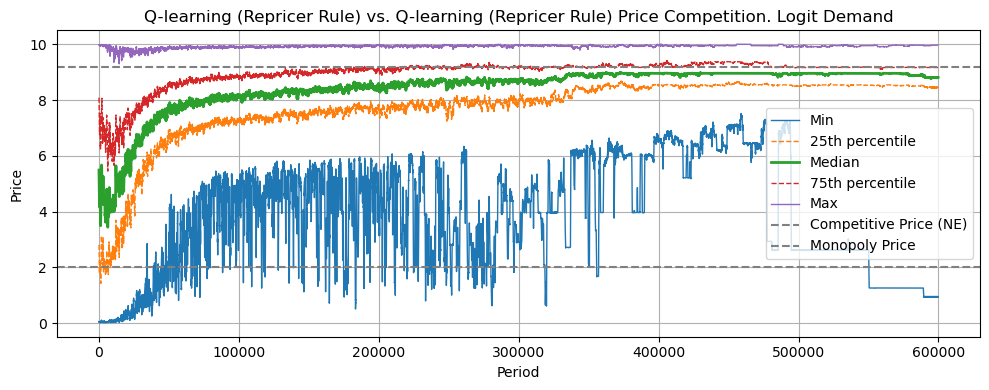

In [7]:
# --- 2) Batch-run Q-rule vs. Q-rule and plot percentiles

# parameters
runs    = 50
periods = 600_000
alpha   = 0.15
gamma   = 0.9

# simulate
batch_qrqr = simulate_batch(
    periods=periods,
    runs=runs,
    alpha=alpha,
    gamma=gamma,
    env=env,
    simfunc=simulate_QrQr
)
price_hist_qrqr, action_hist_qrqr, profit_hist_qrqr = batch_qrqr
# compute percentiles and plot
pc_qrqr = np.percentile(price_hist_qrqr, [0,25,50,75,100], axis=0)
plot_percentiles(
    percentiles=pc_qrqr,
    periods=periods,
    title="Q-learning (Repricer Rule) vs. Q-learning (Repricer Rule) Price Competition. Logit Demand",
    save_path=os.path.join(FIGURE_DIR, "q-learning-rule-vs-q-learning-rule-price-competition.png"),
    ne_price=p_nash,
    mono_price=p_mono
)

In [8]:
# Save the last 1000 periods of price history, action history, and profit history
save_simulation_results(
    price_hist=price_hist_qrqr[:,-1000:],
    action_hist=action_hist_qrqr[:,-1000:],
    profit_hist=profit_hist_qrqr[:,-1000:],
    file_prefix="q-learning-rule-vs-q-learning-rule-price-competition",
    data_dir=DATA_DIR
)

Simulation complete. Data saved to CSV files with prefix 'q-learning-rule-vs-q-learning-rule-price-competition'.


In [9]:
# --- 3) Define simulate_QrQr: two rule-based agents competing
def simulate_QrDummyQrDummy(env, periods, alpha=0.1, gamma=0.9):
    """
    Simulate a Dummy-Q-learning-rule vs. Dummy-Q-learning-rule price competition.

    Parameters
    ----------
    env : pricing environment instance
        Must have .reset(), .step(), .prices, .cost
    periods : int
        Number of time steps to simulate
    alpha, gamma : float
        Learning rate and discount factor for Q-learning

    Returns
    -------
    history1 : np.ndarray
        Time series of firm 1's chosen prices
    """
    n_actions = len(env.prices)

    # Initialize both dummy rule-based agents
    agent0 = DummyQLearningRuleAgent(n_actions, alpha=alpha, gamma=gamma, cost=env.cost)
    agent1 = DummyQLearningRuleAgent(n_actions, alpha=alpha, gamma=gamma, cost=env.cost)

    # Track price history
    history0 = np.zeros(periods)
    history1 = np.zeros(periods)
    history_action_0 = np.zeros(periods)
    history_action_1 = np.zeros(periods)

    history_profit_0 = np.zeros(periods)
    history_profit_1 = np.zeros(periods)
    # Initialize the environment
    (obs_0, obs_1), info = env.reset()

    for t in range(periods):
        # Each agent selects a price index based on rules
        a0 = agent0.take_action(rival_pre_price_idx=obs_1, own_pre_price_idx=obs_0)
        a1 = agent1.take_action(rival_pre_price_idx=obs_0, own_pre_price_idx=obs_1)

        # Step the environment
        (next_obs_0, next_obs_1), (r0, r1), term, trunc, info = env.step((a0, a1))

        # Update each agent based on the reward they received
        agent0.update(agent0.current_rule, r0)
        agent1.update(agent1.current_rule, r1)

        # Record prices
        history0[t] = env.prices[a0]
        history1[t] = env.prices[a1]

        # Record actions
        history_action_0[t] = agent0.current_rule
        history_action_1[t] = agent1.current_rule

        # Record profits
        history_profit_0[t] = r0
        history_profit_1[t] = r1

        # Advance the simulation
        obs_0, obs_1 = next_obs_0, next_obs_1

        if term or trunc:
            break

    return history1, history_action_1, history_profit_1  # shape (periods,). Stores firm-1 price history, which is rule-based.

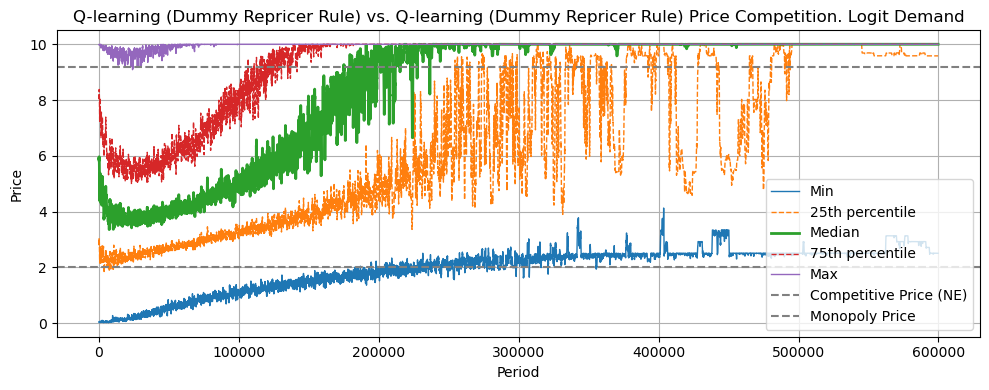

In [10]:
# --- 4) Batch-run Dummy Q-rule vs. Dummy Q-rule and plot percentiles

# parameters
runs    = 50
periods = 600_000
alpha   = 0.15
gamma   = 0.9

env = LogitDemandPricingEnv(
    price_min = 0.01,
    price_max = 10.0,
    grid_size = 25,
    marginal_cost = 2.0,
    beta = 0.95,
    a_0=0, # parameter for logit demand. OUtside option
    a_12=10, # parameter for logit demand. Inside option
    mu = 0.25 # parameter for logit demand. Vertical differentiation
)

# simulate
batch_qrqr_dummy = simulate_batch(
    periods=periods,
    runs=runs,
    alpha=alpha,
    gamma=gamma,
    env=env,
    simfunc=simulate_QrDummyQrDummy
)

price_hist_qrqr_dummy, action_hist_qrqr_dummy, profit_hist_qrqr_dummy = batch_qrqr_dummy
# compute percentiles and plot
pc_qrqr_dummy = np.percentile(price_hist_qrqr_dummy, [0,25,50,75,100], axis=0)
plot_percentiles(
    percentiles=pc_qrqr_dummy,
    periods=periods,
    title="Q-learning (Dummy Repricer Rule) vs. Q-learning (Dummy Repricer Rule) Price Competition. Logit Demand",
    save_path=os.path.join(FIGURE_DIR, "q-learning-dummy-rule-vs-q-learning-dummy-rule-price-competition.png"),
    ne_price=p_nash,
    mono_price=p_mono
)

In [11]:
# save the last 1000 periods of price history, action history, and profit history
save_simulation_results(
    price_hist=price_hist_qrqr_dummy[:, -1000:],
    action_hist=action_hist_qrqr_dummy[:, -1000:],  # corrected variable name
    profit_hist=profit_hist_qrqr_dummy[:, -1000:],  # corrected variable name
    file_prefix="q-learning-dummy-rule-vs-q-learning-dummy-rule-price-competition",  # updated file prefix
    data_dir=DATA_DIR
)

Simulation complete. Data saved to CSV files with prefix 'q-learning-dummy-rule-vs-q-learning-dummy-rule-price-competition'.


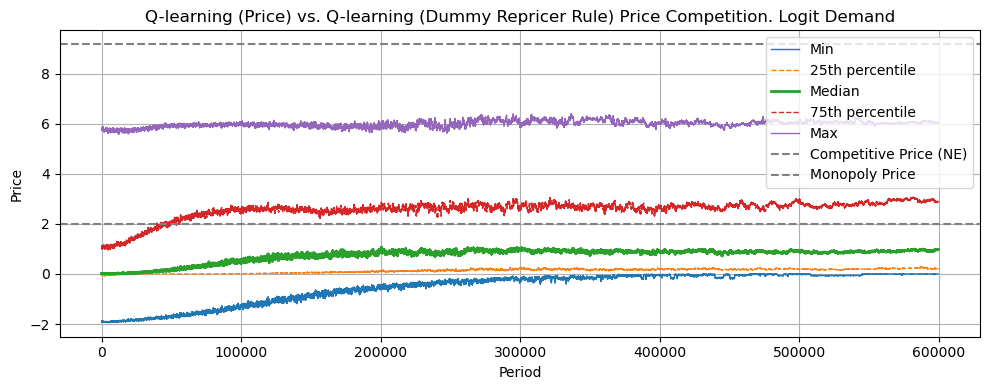

In [12]:
def simulate_QpQrDummy(env, periods, alpha=0.1, gamma=0.9):
    """
    Run a Q-pricing agent vs. Dummy-Q-learning-rule agent competition for `periods` steps.
    
    Returns
    -------
    history1 : np.ndarray, shape (periods,)
        The time series of firm 1's chosen prices (the Dummy-Q-rule agent).
    """
    # --- 1) Create two agents
    n_actions = len(env.prices)
    agent0 = QLearningAgent(
        n_actions=n_actions,
        alpha=alpha,
        gamma=gamma,
        prices=env.prices,
        cost=env.cost
    )
    agent1 = DummyQLearningRuleAgent(
        n_actions=n_actions,
        alpha=alpha,
        gamma=gamma,
        cost=env.cost
    )

    # --- 2) Price history tracking
    history0 = np.zeros(periods)
    history1 = np.zeros(periods)
    history_action_0 = np.zeros(periods)
    history_action_1 = np.zeros(periods)

    history_profit_0 = np.zeros(periods)
    history_profit_1 = np.zeros(periods)

    # --- 3) Initialize environment
    (obs_0, obs_1), info = env.reset()
    state0 = joint_to_index(obs_0, obs_1, n_actions)

    # --- 4) Main loop
    for t in range(periods):
        # Q-learning agent picks action based on full state
        a0 = agent0.take_action(state0)
        
        # Dummy Q-rule agent picks action (no state needed)
        a1_price_idx = agent1.take_action(
            rival_pre_price_idx=obs_0,  # rival's last price (agent0)
            own_pre_price_idx=obs_1     # own last price
        )

        # Step environment
        (next_obs_0, next_obs_1), (r0, r1), terminated, truncated, info = env.step((a0, a1_price_idx))

        # Map new observations to next state
        next_state0 = joint_to_index(next_obs_0, next_obs_1, n_actions)

        # Q-learning update
        agent0.update(state0, a0, r0, next_state0)
        
        # Dummy agent update (no state)
        agent1.update(agent1.current_rule, r1)

        # Record price history
        history0[t] = env.prices[a0]
        history1[t] = env.prices[a1_price_idx]

        # Record actions
        history_action_0[t] = a0
        history_action_1[t] = agent1.current_rule
        # Record profits
        history_profit_0[t] = r0
        history_profit_1[t] = r1

        # Move forward
        obs_0, obs_1 = next_obs_0, next_obs_1
        state0 = next_state0

        if terminated or truncated:
            break

    return history1, history_action_1, history_profit_1  # shape (periods,). Stores firm-1 price history, which is rule-based.
# --- parameters
runs    = 50
periods = 600_000
alpha   = 0.15
gamma   = 0.9

# --- environment setup
env = LogitDemandPricingEnv(
    price_min=0.01,
    price_max=10.0,
    grid_size=25,
    marginal_cost=2.0,
    beta=0.95,
    a_0=0,      # outside option
    a_12=10,    # inside option coefficient
    mu=0.25     # vertical differentiation
)

# --- simulate: Q-pricing vs Dummy Q-rule
batch_qpqr_dummy = simulate_batch(
    periods=periods,
    runs=runs,
    alpha=alpha,
    gamma=gamma,
    env=env,
    simfunc=simulate_QpQrDummy
)

price_hist_qpqr_dummy, action_hist_qpqr_dummy, profit_hist_qpqr_dummy = batch_qpqr_dummy

# --- compute percentiles and plot
pc_qpqr_dummy = np.percentile(profit_hist_qpqr_dummy, [0, 25, 50, 75, 100], axis=0)

plot_percentiles(
    percentiles=pc_qpqr_dummy,
    periods=periods,
    title="Q-learning (Price) vs. Q-learning (Dummy Repricer Rule) Price Competition. Logit Demand",
    save_path=os.path.join(FIGURE_DIR, "q-learning-price-vs-dummy-rule-price-competition.png"),
    ne_price=p_nash,
    mono_price=p_mono
)

In [13]:
# save the last 1000 periods of price history, action history, and profit history
save_simulation_results(
    price_hist=price_hist_qpqr_dummy[:, -1000:],
    action_hist=action_hist_qpqr_dummy[:, -1000:],
    profit_hist=profit_hist_qpqr_dummy[:, -1000:],
    file_prefix="q-learning-price-vs-dummy-rule-price-competition",
    data_dir=DATA_DIR
)

Simulation complete. Data saved to CSV files with prefix 'q-learning-price-vs-dummy-rule-price-competition'.
